In [104]:
# imports and defaults
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import numpy as np
import os
import path_weighting as pw
import cn_derivations as cn
import data_parser as dp
import math
import mpmath

mpmath.dps = 30
mpmath.pretty = True

pd.options.display.max_rows = 10
import seaborn as sns
sns.set_style('ticks')
sns.set_context('talk')
os.getcwd()

'/home/nick/PycharmProjects/Feldkurs/ss19-feldkurs/Pycode'

In [50]:
"""Data overview"""
filename = "2019-05-24"
scint_data = dp.scintillometer_parse(filename)
scint_data

,Cn2,CT2,H_convection,crosswind,sigCrosswind,pressure,temp,humidity,pathLength,pathHeight,...,<XA>(c),<YA>(c),nSigXA(c),nSigYA(c),corXAYA(c),numDgnValid,numDgnValidCrosswind,numDgnTotal,channelFlagsCombined,error
Time,,,,,,,,,,,,,,,,,,,,,
2019-05-24 05:26:00+00:00,1.911500e-16,0.000193,4.6,NaN,NaN,1010.0,9.0,81,2032,25.62,...,20451.6,20609.4,0.010469,0.011068,-0.004,1,0,1,0,1
2019-05-24 05:27:00+00:00,2.447200e-16,0.000248,5.5,NaN,NaN,1010.0,9.0,81,2032,25.62,...,20465.4,20579.2,0.013037,0.013001,0.120,2,0,2,0,1
2019-05-24 05:28:00+00:00,2.616500e-16,0.000265,5.8,NaN,NaN,1010.0,9.0,81,2032,25.62,...,20346.9,20589.7,0.012148,0.013691,0.048,2,0,2,0,1
2019-05-24 05:29:00+00:00,2.964500e-16,0.000300,6.4,NaN,NaN,1010.0,9.0,81,2032,25.62,...,20477.3,20494.0,0.013917,0.013173,0.016,2,0,2,0,1
2019-05-24 05:30:00+00:00,2.020200e-16,0.000204,4.8,NaN,NaN,1010.0,9.0,81,2032,25.62,...,20428.3,20515.5,0.012816,0.010916,0.131,2,0,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-24 16:36:00+00:00,1.493400e-15,0.001511,21.4,NaN,NaN,1010.0,9.0,81,2032,25.62,...,17427.2,18494.8,0.029496,0.033662,0.093,2,0,2,0,1
2019-05-24 16:37:00+00:00,2.033100e-15,0.002057,26.9,NaN,NaN,1010.0,9.0,81,2032,25.62,...,17469.0,18561.4,0.037205,0.035720,0.071,2,0,2,0,1
2019-05-24 16:38:00+00:00,1.957600e-15,0.001981,26.2,NaN,NaN,1010.0,9.0,81,2032,25.62,...,17478.6,18564.7,0.043701,0.037374,0.280,2,0,2,0,1


In [81]:
k = 0.4  # von Karman constant
cp = 1004  # J kg^-1 K^-1, heat capacity of air
r_d = 287.05  # J kg^-1 K^-1, specific gas constant for dry air
beta_1 = 0.86
g = 9.81

station = "schiessstand"
filename = "2019-05-24"
z_eff = pw.return_z_effective(station)
cdf = cn.derive_ct2(file_name)
# Calculate kinematic surface heat flux
cdf["Q_0"] = 1.165 * k * z_eff * (cdf["CT2"] ** (3 / 4)) * (
    g / cdf["temperature"]) ** (1 / 2)

# Air density
cdf["rho_air"] = 100 * cdf["pressure"] / (
    r_d * cdf["temperature"])
# Surface sensible heat flux under free convection
cdf["H_free"] = cdf["Q_0"] * cp * cdf["rho_air"]

Please enter the stability conditions (stable, unstable, or other):
u
Mean path height: 31.83766108843537m
Effective path height: 25.62897860987237m


In [106]:
"""Obukhov iteration definition"""


def obukhov_iteration(row_index, inital_length=-1000.0):
    """Calculates Obukhov length using procedure in SRun Theory Manual
    Args:
        inital_length (float): inital guess for Obukhov length, default
            initial_length = -1000.0
    Returns:
        l_ob (pandas.core.series.Series): dataframe of computed Obukhov
            lengths for each time interval.
    """

    # Calculate corresponding value for f_H for unstable conditions
    zeta = z_eff / inital_length
    if zeta < 0:
        f_H = 4 * (k ** (-2 / 3)) * beta_1 * (
                1 - 7 * zeta + 75 * zeta ** 2) ** (
                      -1 / 3)
    else:
        f_H = 4 * (k ** (-2 / 3)) * beta_1 * (
                1 + 7 * zeta + 20 * zeta ** 2) ** (
                      -1 / 3)

    # Calculate temperature scale θ* with measured CT2
    cdf["theta_star"] = np.sqrt(
        (cdf["CT2"].loc[row_index] * (z_eff ** (2 / 3))) / f_H)
    # Calculate corresponding value for Ψ_M for unstable conditions
    # using L_Ob and the height of the wind sensor z_u.
    z_u = 579  # from ZAMG
    x = mpmath.power((1 - 15 * zeta), (1 / 4))
    
    if zeta < 0:
        psi_M = -2 * math.log((1 + x) / 2) - math.log(
            (1 + x ** 2) / 2) + 2 * math.atan(x) - \
                math.pi / 2
    else:
        psi_M = 4.7 * zeta

    # Calculate friction velocity u*. Horizontal wind speed U(z_u)
    # roughness length z_0 are required.
    z_0 = 0.1 * z_u

    cdf["u_star"] = k * cdf[
        "windspeed"].loc[row_index] / (math.log(z_u / z_0) - psi_M)

    # Calculate Obukhov length
    l_obu = (cdf["temperature"].loc[row_index] *
             cdf["u_star"].loc[row_index] ** 2) / (
                    k * g * cdf["theta_star"].loc[row_index])
    return l_obu

In [115]:
"""Calculate fluxes using iterative scheme"""
for index, row in cdf.iterrows():
    # Initialise first iteration step
    ob_ini = -1000
    l_ob = obukhov_iteration(index, ob_ini)
    cdf.loc[index, "l_ob"] = l_ob
    step = 0
    while abs(l_ob - ob_ini) > 0.1:
        step += 1
        ob_prev = ob_ini
        ob_ini = l_ob
        l_ob = obukhov_iteration(index, ob_ini)
        # avoid infinite loops
        if math.isclose(l_ob, ob_prev, rel_tol=0.1) or step > 1000:
            break

print("Iteration completed!")
# Calculate sensible heat flux
cdf["H"] = -cdf["rho_air"] * cp * cdf["theta_star"] * cdf["u_star"]
# Calculate momentum flux
cdf["momentum_flux"] = cdf["rho_air"] * cdf[
    "u_star"] ** 2


Iteration completed!


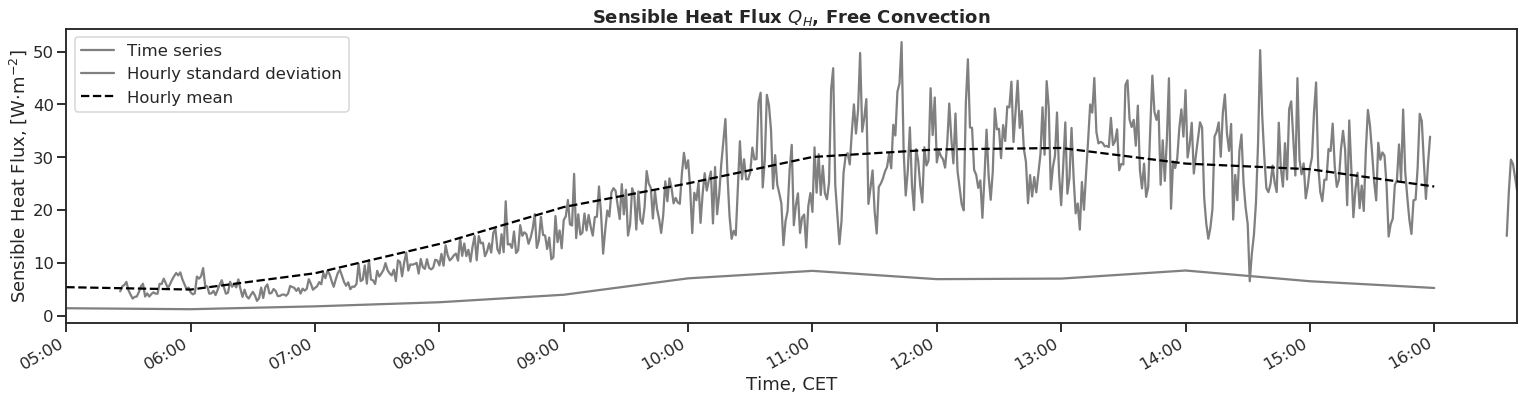

In [108]:
hourly_mean = cdf.resample("H").mean()
hourly_mean["H_free_std"] = cdf["H_free"].resample("H").std()

fig = plt.figure(figsize=(26, 6))
cdf["H_free"].plot(color="grey", label="Time series")
hourly_mean["H_free_std"].plot(label="Hourly standard deviation", color="grey")
hourly_mean["H_free"].plot(label="Hourly mean", color="black",
                         linestyle="dashed")

plt.legend(loc="upper left")
plt.title(r"Sensible Heat Flux $Q_{H}$, Free Convection", fontweight="bold")
plt.xlabel("Time, CET")
plt.ylabel("Sensible Heat Flux, [W$\cdot$m$^{-2}$]")
ax = plt.gca()
ax.xaxis.set_major_formatter(dates.DateFormatter('%H:%M'))  # hours and minutes
plt.show()

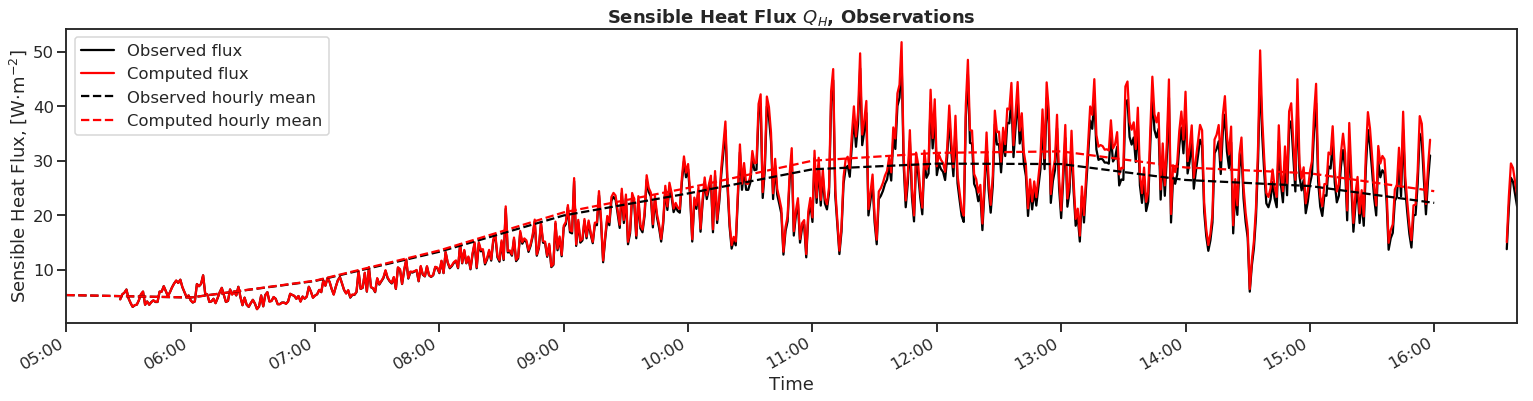

In [109]:
hourly_scint_mean = scint_data.resample("H").mean()
hourly_scint_mean["H_std"] = scint_data["H_convection"].resample("H").std()

plt.figure(figsize=(26, 6))
scint_data["H_convection"].plot(color="black", label="Observed flux")
(cdf["H_free"]).plot(color="red", label="Computed flux")

hourly_scint_mean["H_convection"].plot(label="Observed hourly mean", color="black",
                                        linestyle="dashed")
hourly_mean["H_free"].plot(label="Computed hourly mean", color="red",
                      linestyle="dashed")

plt.legend(loc="upper left")
plt.title(r"Sensible Heat Flux $Q_{H}$, Observations", fontweight="bold")
plt.xlabel("Time")
plt.ylabel("Sensible Heat Flux, [W$\cdot$m$^{-2}$]")
ax = plt.gca()
ax.xaxis.set_major_formatter(dates.DateFormatter('%H:%M'))  # hours and minutes
plt.show()

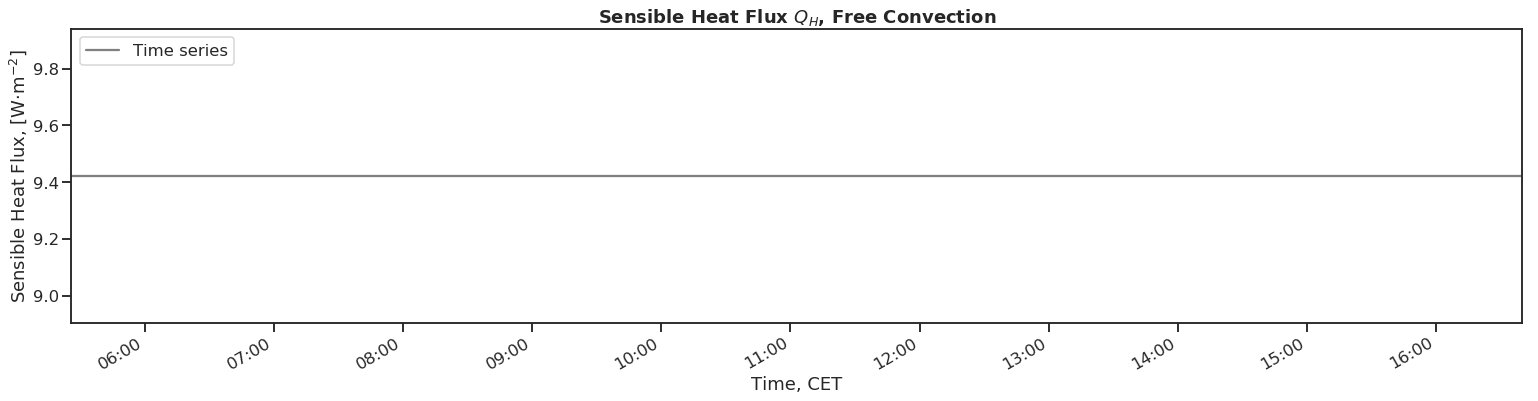

In [123]:
cdf["H"] = -cdf["rho_air"] * cp * cdf["theta_star"] * cdf["u_star"]

hourly_mean = cdf.resample("H").mean()
hourly_mean["H_std"] = cdf["H"].resample("H").std()

fig = plt.figure(figsize=(26, 6))
(cdf["H"]).plot(color="grey", label="Time series")
# hourly_mean["H_std"].plot(label="Hourly standard deviation", color="grey")
# hourly_mean["H"].plot(label="Hourly mean", color="black",
#                          linestyle="dashed")

plt.legend(loc="upper left")
plt.title(r"Sensible Heat Flux $Q_{H}$, Free Convection", fontweight="bold")
plt.xlabel("Time, CET")
plt.ylabel("Sensible Heat Flux, [W$\cdot$m$^{-2}$]")
ax = plt.gca()
ax.xaxis.set_major_formatter(dates.DateFormatter('%H:%M'))  # hours and minutes
plt.show()